In [14]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

train_dir = './train_images'
test_dir = './test_images'

transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

train_data_size = len(train_data)
test_data_size = len(test_data)

## Visualise the data

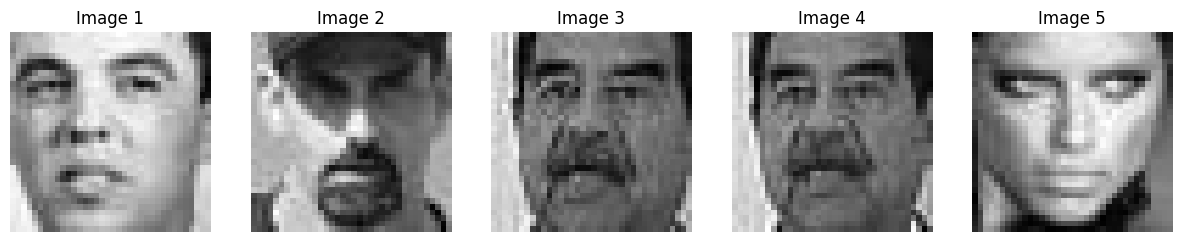

In [5]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# Directory containing the .pgm images
directory = './train_images/1'

# List all the .pgm files in the directory
pgm_files = [f for f in os.listdir(directory) if f.endswith('.pgm')]

# Define the number of images you want to display
num_images_to_display = min(5, len(pgm_files))

# Create a subplot for the grid of images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

# Loop through and display the selected number of .pgm images
for i in range(num_images_to_display):
    image_path = os.path.join(directory, pgm_files[i])
    
    # Open the .pgm image using PIL (Pillow)
    image = Image.open(image_path)
    
    # Display the image on the current subplot
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')  # Turn off axis labels

plt.show()


In [2]:
from torch.utils.data.sampler import SubsetRandomSampler

valid_size = 0.2
batch_size = 32
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=5)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=5)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=5)
classes = ('noface','face')

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_3_layers_no_augmentation = Net().to(device)

In [6]:
def train_NN(n_epochs, optimizer, model, criterion):
    for epoch in range(1, n_epochs+1):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # print statistics after every epoch
        print(f'[{epoch}, {i + 1:5d}] loss: {running_loss / len(train_loader):.3f}')

    print('Finished Training')

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(model_3_layers_no_augmentation.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

train_NN(n_epochs, optimizer_SGD, model_3_layers_no_augmentation, criterion)

# save the model after training
PATH = 'models/original.pth'
torch.save(model_3_layers_no_augmentation.state_dict(), PATH)

[1,  2293] loss: 0.600
[2,  2293] loss: 0.229
[3,  2293] loss: 0.115
[4,  2293] loss: 0.078
[5,  2293] loss: 0.057
[6,  2293] loss: 0.045
[7,  2293] loss: 0.037
[8,  2293] loss: 0.032
[9,  2293] loss: 0.027
[10,  2293] loss: 0.024
[11,  2293] loss: 0.021
[12,  2293] loss: 0.018
[13,  2293] loss: 0.017
[14,  2293] loss: 0.016
[15,  2293] loss: 0.014
[16,  2293] loss: 0.012
[17,  2293] loss: 0.011
[18,  2293] loss: 0.010
[19,  2293] loss: 0.008
[20,  2293] loss: 0.009
Finished Training


In [5]:
def get_classifier_accuracy(model):
    # number of no face and face images in the test dataset
    NO_FACE = 6831
    FACE = 797

    correct = 0
    correct_no_face = 0
    correct_has_face = 1
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct_no_face += ((predicted == 0) & (labels == 0)).sum().item()
            correct_has_face += ((predicted == 1) & (labels == 1)).sum().item()
            correct += (predicted == labels).sum().item()
    
    print("correct no face = {:.2f}, has face = {:.2f}".format(100 * correct_no_face / NO_FACE, 100 * correct_has_face / FACE))

    return 100 * correct / total

In [6]:
model_3_layers_no_augmentation.load_state_dict(torch.load('models/original.pth'))

model_accuracy = get_classifier_accuracy(model_3_layers_no_augmentation)
print('Accuracy of the 3-layer no augmentation classifier on the {} test images: {:.2f}'.format(test_data_size, model_accuracy))

correct no face = 99.30, has face = 36.76
Accuracy of the 3-layer no augmentation classifier on the 7628 test images: 92.75


We notice that during the training, the loss value decrease very quickly, from epoch 9 it almost doesn't change. It suggests that the model might be overfitting

In [10]:
import torch.optim as optim

# retrain with 9 epochs
criterion = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(model_3_layers_no_augmentation.parameters(), lr=0.001, momentum=0.9)
n_epochs_2 = 9

train_NN(n_epochs_2, optimizer_SGD, model_3_layers_no_augmentation, criterion)

[1,  2293] loss: 0.600
[2,  2293] loss: 0.229
[3,  2293] loss: 0.115
[4,  2293] loss: 0.078
[5,  2293] loss: 0.057
[6,  2293] loss: 0.045
[7,  2293] loss: 0.037
[8,  2293] loss: 0.032
[9,  2293] loss: 0.027
Finished Training


In [11]:
model_accuracy_2 = get_classifier_accuracy(model_3_layers_no_augmentation)
print('Accuracy of the 3-layer no augmentation classifier on the {} test images: {:.2f}'.format(test_data_size, model_accuracy_2))

Accuracy of the 3-layer no augmentation classifier on the 7628 test images: 91.41


The accuracy is lower with lower epoch, so that's about how good this model is